In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    distance = np.random.uniform(low=1, high=3, size=len(G.edges))
    for ((a, b), d) in zip(G.edges, distance):
        G.edges[a, b]["distance"] = d
        G.edges[a, b]["delay"] = f"uniform {d * 0.5} {d * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / d
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "ocaml/bin/igraph_runner.exe"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.199777,1.920277,0.520758,1.511341,0.661664
1,0.148184,2.572069,0.388792,2.011230,0.497208
2,0.110049,4.239001,0.235905,3.681393,0.271636
3,0.122948,2.914528,0.343109,2.586928,0.386559
4,0.210426,2.898952,0.344952,2.210077,0.452473
5,0.017280,2.601190,0.384439,2.376069,0.420863
6,0.191335,2.582830,0.387172,2.055470,0.486507


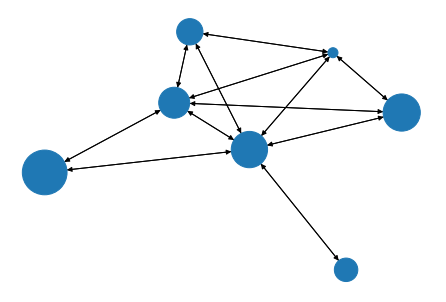

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

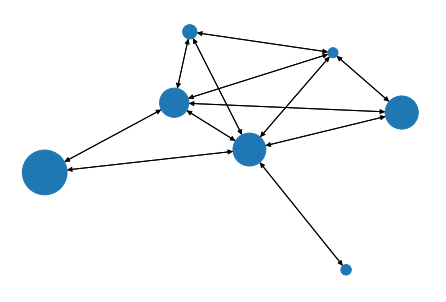

In [5]:
draw(G, size="reward", layout=layout)

In [6]:
runs = []
for i in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in ["nakamoto", "ethereum", "tailstorm 8 constant", "tailstorm 8 discount"]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
            seed=i,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
0,78.0,53.000,0.581674,1.719176,0.475976,2.100948,0.076582,nakamoto,0.001577,0.001325,0.786445
1,135.0,99.000,0.649737,1.539084,0.362665,2.757362,0.139283,nakamoto,0.002945,0.002475,0.807708
2,68.0,19.000,0.255365,3.915964,0.238124,4.199488,0.063826,nakamoto,0.000565,0.000475,0.338278
3,92.0,43.000,0.438208,2.282021,0.307504,3.251985,0.106723,nakamoto,0.001279,0.001075,0.457855
4,33.0,14.000,0.347200,2.880184,0.314956,3.175044,0.045287,nakamoto,0.000417,0.000350,0.351293
...,...,...,...,...,...,...,...,...,...,...,...
2,32.0,17.125,0.214709,4.657477,0.219679,4.552097,0.032036,tailstorm 8 discount,0.000509,0.000428,0.607446
3,93.0,61.250,0.385482,2.594153,0.345113,2.897606,0.099917,tailstorm 8 discount,0.001822,0.001531,0.696601
4,295.0,205.375,0.384740,2.599161,0.270734,3.693664,0.267359,tailstorm 8 discount,0.006110,0.005134,0.872912
5,165.0,126.125,0.559170,1.788364,0.407174,2.455953,0.169201,tailstorm 8 discount,0.003752,0.003153,0.847062


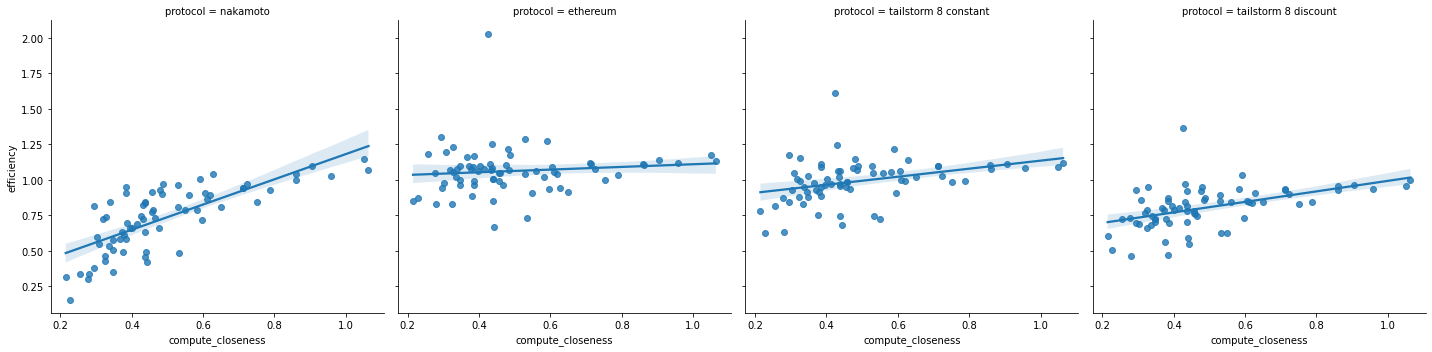

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")